In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs) #preferences and font stuff.
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

#import warnings
#warnings.filterwarnings('ignore')
#from IPython.display import Markdown, display

%matplotlib inline

/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:46: UserWarning: Neither Python Excel module ('openpyxl','xlrd') found
  warnings.warn("Neither Python Excel module ('openpyxl','xlrd') found",UserWarning)


In [2]:
year=2009
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [3]:
display(Markdown('''## Year: '''+ str(year)))

NameError: name 'Markdown' is not defined

In [4]:
display(Markdown('''### Model output: '''+ PATH))

NameError: name 'Markdown' is not defined

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

### load observations

In [5]:
dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb')) # a list of the stations.

In [6]:
dfSta.head()

,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude
Station,,,,,,
ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933
ADM002,C,Admiralty Inlet (north) - Quimper Pn.,Admiralty Inlet,79,48.187318,-122.842950
ADM003,C,Admiralty Inlet (south),Admiralty Inlet,118,47.878983,-122.483195
BLL009,C,Bellingham Bay - Pt. Frances,Strait of Georgia,31,48.685940,-122.599618
BUD005,C,Budd Inlet - Olympia Shoal,South Basin,22,47.092040,-122.918197


In [7]:
dfBot=pickle.load(open(os.path.join(datadir,f'Bottles_{str(year)}.p'),'rb')) #the actual observed statistics. 

In [8]:
dfBot.head()

,Station,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom
0,ADM001,2009-04-06,2009-04-06 19:02:00,-29.737,2.326720,54.957096,26.395241,0.420664,0.994396,27.810301,-30.0
1,ADM001,2009-04-06,2009-04-06 19:02:00,-9.866,2.329884,54.869972,26.359756,0.427531,0.887487,27.674774,-10.0
2,ADM001,2009-04-06,2009-04-06 19:02:00,-1.014,2.321841,55.717751,26.358368,0.424185,0.767900,27.550453,-0.0
3,ADM001,2009-05-20,2009-05-20 19:35:00,-29.652,1.857458,43.407459,17.997786,0.340660,2.840845,21.179290,-30.0
4,ADM001,2009-05-20,2009-05-20 19:35:00,-9.818,1.412211,44.223774,13.289508,0.283774,1.721990,15.295271,-10.0


In [9]:
df1=pd.merge(left=dfSta,right=dfBot,how='right',
             left_on='Station',right_on='Station')# this tells us to join station with station, specifies the keys so that it does not choose everykey to join. 
#right join means all rows in right table (dfBot) are included in output
df1.head()

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,-29.737,2.326720,54.957096,26.395241,0.420664,0.994396,27.810301,-30.0
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,-9.866,2.329884,54.869972,26.359756,0.427531,0.887487,27.674774,-10.0
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,-1.014,2.321841,55.717751,26.358368,0.424185,0.767900,27.550453,-0.0
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-05-20,2009-05-20 19:35:00,-29.652,1.857458,43.407459,17.997786,0.340660,2.840845,21.179290,-30.0
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-05-20,2009-05-20 19:35:00,-9.818,1.412211,44.223774,13.289508,0.283774,1.721990,15.295271,-10.0


In [10]:
# check that there are no stations without lat and lon
df1.loc[pd.isnull(df1['Latitude'])] #seeing if there are any null values in latitude. 

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom


In [11]:
#check on to one matches:
len(df1),len(dfBot), len(dfSta)

(571, 571, 39)

In [12]:
# We require the following columns:
#    dtUTC datetime
#    Lat   Latitude
#    Lon   Longitude
#    Z     Depth, increasing downward (positive)
df1.rename(columns={'UTCDateTime':'dtUTC','Latitude':'Lat','Longitude':'Lon'},inplace=True)
df1['Z']=-1*df1['Z']
df1.head() #just renaming. 

,Station,Desig,Descrip,Basin,Max_Depth,Lat,Lon,Date,dtUTC,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,29.737,2.326720,54.957096,26.395241,0.420664,0.994396,27.810301,-30.0
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,9.866,2.329884,54.869972,26.359756,0.427531,0.887487,27.674774,-10.0
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,1.014,2.321841,55.717751,26.358368,0.424185,0.767900,27.550453,-0.0
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-05-20,2009-05-20 19:35:00,29.652,1.857458,43.407459,17.997786,0.340660,2.840845,21.179290,-30.0
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-05-20,2009-05-20 19:35:00,9.818,1.412211,44.223774,13.289508,0.283774,1.721990,15.295271,-10.0


In [13]:
# It will also be useful to add/rename the following columns:
df1['NO23']=df1['NO3(uM)D']+df1['NO2(uM)D'] # the model does not distinguish between NO2 and NO3
df1['Amm']=df1['NH4(uM)D']
df1['Si']=df1['SiOH4(uM)D']
df1['Year']=[ii.year for ii in df1['dtUTC']]
df1['YD']=et.datetimeToYD(df1['dtUTC'])

In [14]:
print(len(df1),'data points')
print('Number of data points in each region:')
df1.groupby('Basin')['NO23'].count()

571 data points
Number of data points in each region:


Basin
Admiralty Inlet       72
Grays Harbor          27
Hood Canal Basin      49
Main Basin           109
South Basin          130
Strait of Georgia     58
Whidbey Basin         61
Willapa Bay           65
Name: NO23, dtype: int64

### set up variables for model-data matching

In [15]:
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)
flen=1 #number of days of model output contained in an output file.
namfmt='nowcast'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T',
         'ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}

What are all of these grids and ptrcs and Ts and what is tmask?

In [16]:
data=et.matchData(df1,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False);

(Lat,Lon)= 46.54537666666667 -123.98016166666666  not matched to domain
(Lat,Lon)= 46.644 -123.993  not matched to domain
(Lat,Lon)= 46.68676333333333 -123.9735  not matched to domain
(Lat,Lon)= 46.68732166666667 -123.74988166666667  not matched to domain
(Lat,Lon)= 46.703986666666665 -123.837385  not matched to domain
(Lat,Lon)= 46.937313333333336 -123.91322333333333  not matched to domain
(Lat,Lon)= 46.953421666666664 -124.09295  not matched to domain
(Lat,Lon)= 46.97787 -123.78461  not matched to domain
(Lat,Lon)= 47.21342666666666 -123.07765  not matched to domain


Here is all the data for the shape of the bottom of the model. 

In [49]:
data.dtUTC

0     2009-03-11 18:30:00
1     2009-03-11 18:30:00
2     2009-03-11 18:30:00
3     2009-03-11 19:34:00
4     2009-03-11 19:34:00
              ...        
457   2009-12-22 20:33:00
458   2009-12-22 21:09:00
459   2009-12-22 21:09:00
460   2009-12-22 21:09:00
461   2009-12-22 22:24:00
Name: dtUTC, Length: 462, dtype: datetime64[ns]

In [17]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

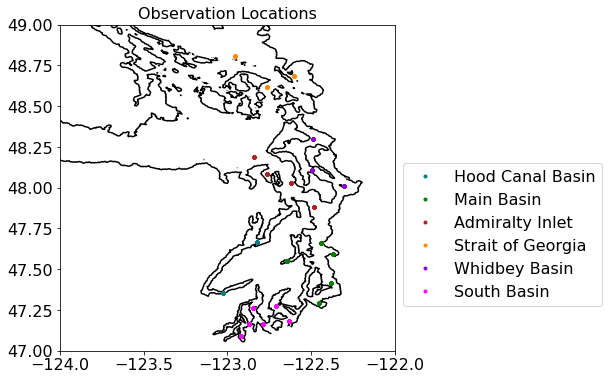

In [18]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid: #you will get data from somewhere else.
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)# cannot set isobath to zero.
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()# This whole datreg thing does something I do not quite understand. 
for ind, iregion in enumerate(data.Basin.unique()): #gives a list of unique values present in column So that each basin has its own color. 
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:]
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [46]:
JFM

,Station,Desig,Descrip,Basin,Max_Depth,Lat,Lon,Date,dtUTC,Z,...,i,mod_nitrate,mod_silicon,mod_ammonium,mod_diatoms,mod_ciliates,mod_flagellates,mod_vosaline,mod_votemper,k
0,HCB004,C,"Hood Canal - Gt. Bend, Sisters Point",Hood Canal Basin,53,47.356205,-123.024873,2009-03-11,2009-03-11 18:30:00,1.042,...,118,16.012035,37.602016,1.435322,0.409200,0.235496,0.430618,22.323891,6.728588,1
1,HCB004,C,"Hood Canal - Gt. Bend, Sisters Point",Hood Canal Basin,53,47.356205,-123.024873,2009-03-11,2009-03-11 18:30:00,9.877,...,118,22.817808,34.589394,0.933944,0.138811,0.131530,0.188983,29.412308,10.142488,9
3,HCB010,C,"Hood Canal - Send Creek, Bangor",Hood Canal Basin,100,47.670000,-122.820000,2009-03-11,2009-03-11 19:34:00,1.039,...,186,17.139961,35.158241,1.257981,0.574897,0.226047,0.510219,26.557316,6.695756,1
4,HCB010,C,"Hood Canal - Send Creek, Bangor",Hood Canal Basin,100,47.670000,-122.820000,2009-03-11,2009-03-11 19:34:00,9.505,...,186,21.567041,36.320904,1.006372,0.277864,0.153770,0.314119,29.078060,8.362720,9
5,ELB015,C,Elliott Bay - E. of Duwamish Head,Main Basin,91,47.596487,-122.369572,2009-03-11,2009-03-11 20:55:00,1.180,...,243,19.744818,36.782860,0.953328,0.225467,0.196198,0.620157,28.480576,8.068970,1
6,ELB015,C,Elliott Bay - E. of Duwamish Head,Main Basin,91,47.596487,-122.369572,2009-03-11,2009-03-11 20:55:00,10.011,...,243,21.608562,37.068798,0.868764,0.120096,0.151437,0.438178,29.174809,8.358791,10
8,SIN001,C,Sinclair Inlet - Naval Shipyards,Main Basin,17,47.549262,-122.643472,2009-03-11,2009-03-11 21:36:00,1.230,...,197,16.762600,38.200630,1.451559,0.459447,0.218406,0.460828,24.270723,5.605001,1
9,SIN001,C,Sinclair Inlet - Naval Shipyards,Main Basin,17,47.549262,-122.643472,2009-03-11,2009-03-11 21:36:00,9.707,...,197,19.804310,36.119560,1.087329,0.377878,0.172363,0.424764,28.326893,7.850124,9
10,PTH005,C,Port Townsend Harbor - Walan Point,Admiralty Inlet,33,48.083148,-122.764612,2009-03-12,2009-03-12 18:07:00,1.175,...,245,22.269247,41.388062,0.896735,0.078048,0.210177,0.470321,29.257130,6.285668,1
11,ADM002,C,Admiralty Inlet (north) - Quimper Pn.,Admiralty Inlet,79,48.187318,-122.842950,2009-03-12,2009-03-12 18:32:00,1.094,...,246,25.085094,41.777092,0.607903,0.019367,0.118456,0.211050,30.932249,7.195125,1


In [19]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)# What does set aspect do?
    return ps,l

def byRegion(ax,obsvar,modvar,lims):
    ps=[]
    for ind, iregion in enumerate(data.Basin.unique()):
        ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb
# all f these in some way or the other call to the full dataset itself. 

In [20]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Hood Canal Basin', 'Main Basin', 'Admiralty Inlet', 'Strait of Georgia', 'Whidbey Basin', 'South Basin'])

# Nitrate

### <font color="cyan"> So this is where statsDict starts. It is an empty dictionary that she slowly fills up with information. Also, Stats subs is a bunch of views of the data itself, so that is where all the data is coming from in these next couple of parts. Also deframe is just responsible for finding that the name is something witin a dataframe and then flattens that dataframe. </font>

In [21]:
obsvar='NO23'
modvar='mod_nitrate'
statsDict={year:dict()} 
statsDict[year]['NO3']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['NO3'][isub]=dict()
    var=statsDict[year]['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],#ET stats just spits out a bunch of statistics, I wish it was more clear about the order it releases them in
                                                                     statsubs[isub].loc[:,[modvar]]) #here is where modvar comes into the mix.
tbl,tdf=et.displayStats(statsDict[year]['NO3'],level='Subset',suborder=list(statsubs.keys())) #what does et.displayStats do. 
tbl
#what does "_deframe" do within the evaltools stats function?

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, JFM
z < 15 m, Apr
z < 15 m, MJJA
z < 15 m, SOND
Hood Canal Basin
Main Basin
Admiralty Inlet
Strait of Georgia
Whidbey Basin
South Basin


/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


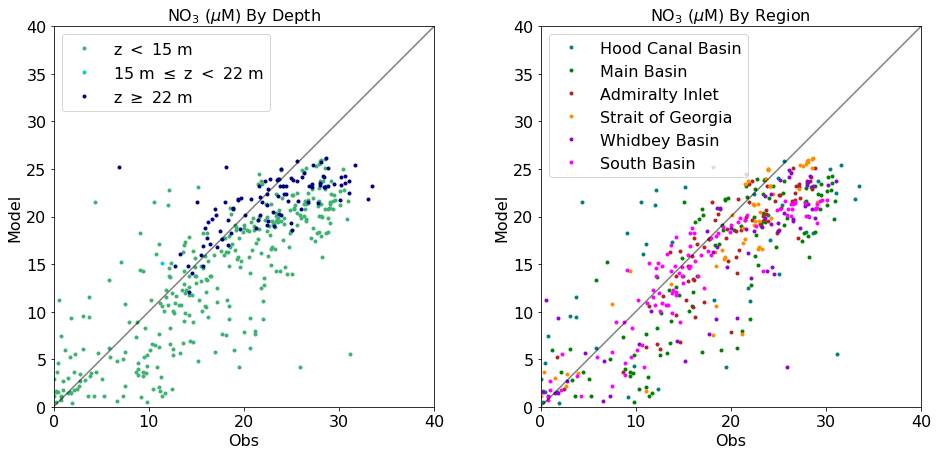

In [22]:
fig, ax = plt.subplots(1,2,figsize = (16,7))#set the number of plots and the size and make them equal to fig and ax
ps,l=byDepth(ax[0],obsvar,modvar,(0,40)) # use ax to fill up the graph. 
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region'); #hmmm what does ; do in Python in this context. 

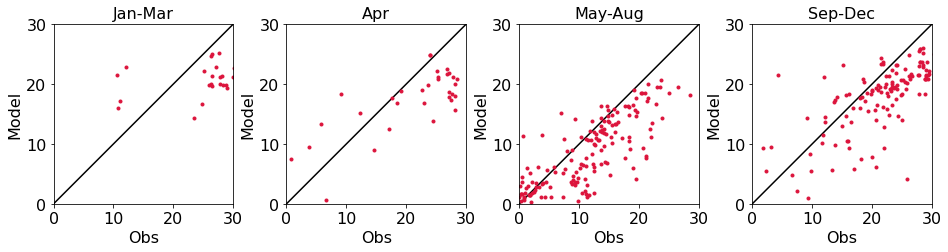

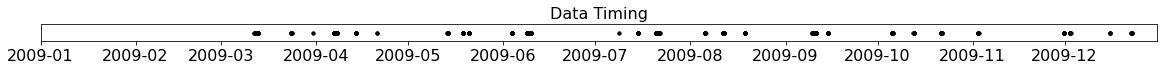

In [23]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3)) # This does all of the little plots. 
bySeason(ax,obsvar,modvar,(0,30))
fig,ax=plt.subplots(1,1,figsize=(20,.3)) # This does the weird thing on the bottom.
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

# Dissolved Silica

In [24]:
obsvar='Si'
modvar='mod_silicon'
statsDict[year]['dSi']=OrderedDict()
for isub in statsubs:
    statsDict[year]['dSi'][isub]=dict()
    var=statsDict[year]['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]], #how does this actually call to the dataframes themselves?
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


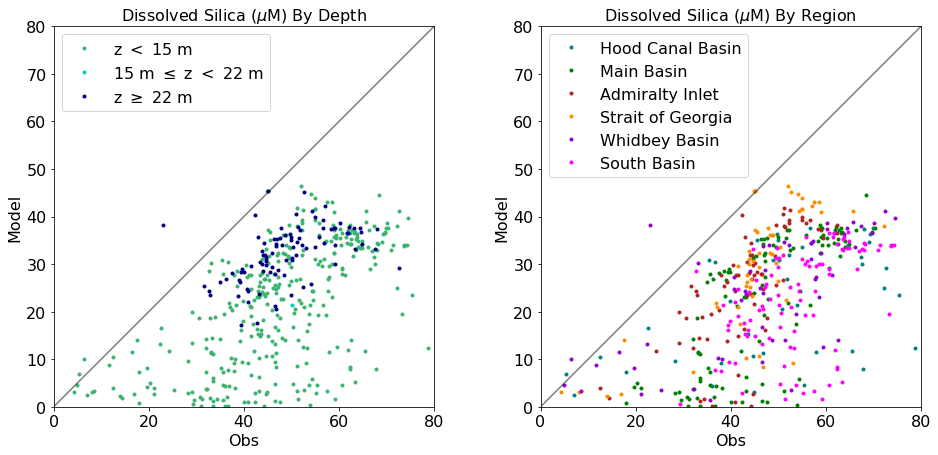

In [25]:
mv=(0,80)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,mv)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,mv)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

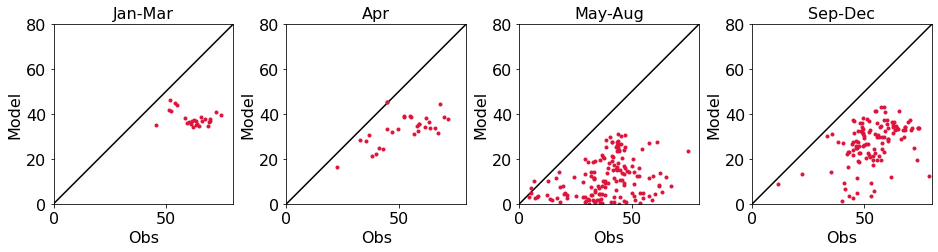

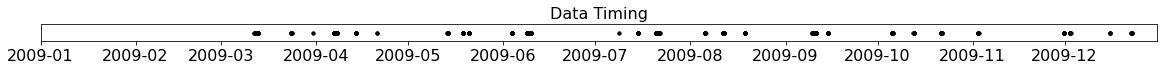

In [26]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Profiles of NO3 and Dissolved Silica

Text(0.5, 1.0, 'dSi')

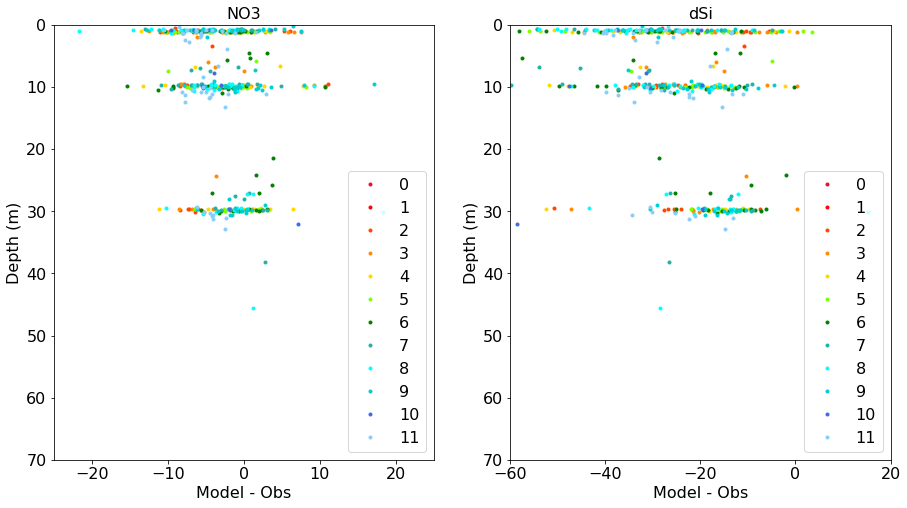

In [27]:
fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['NO23']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(70,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-25,25)
ax[1].set_xlim(-60,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')

# dSi:NO3 Ratios

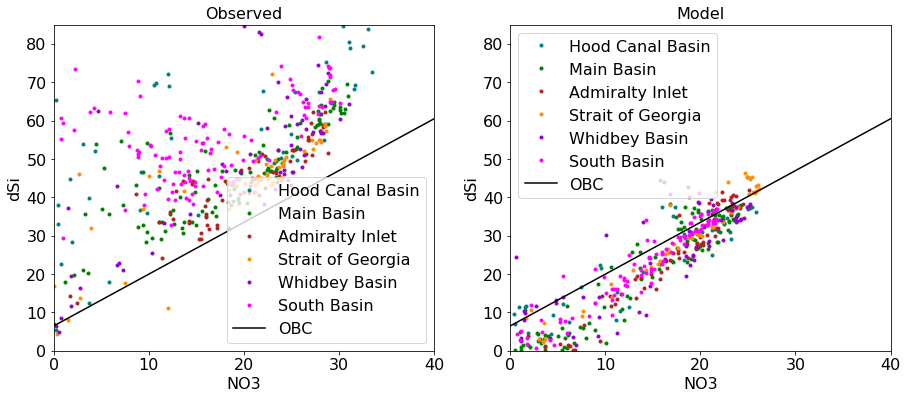

In [28]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()): # I need more info on enumerate.
    p1=ax[0].plot(datreg[iregion]['NO23'],datreg[iregion]['Si'],'.', #I guess you cannot use byRegion here.
                  color=colors[ind],label=iregion) #this for loop takes all of the different basin names and uses that to call the necessary information out of datreg I think ind is something we set up while making the map. 
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC') # This just creates the correlation line needed for these kinds of plots. 
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_nitrate'],datreg[iregion]['mod_silicon'],'.',
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

Note the close correlation between nitrate and silicon in the model. In puget sound, the ratios is based on silicate brought in by the rivers (most likely) so it is reasonable that it might look like this. 

# NH4

These first parts are all about creating tables, and have basically nothing to do with the graphing

In [44]:
obsvar='Amm'
modvar='mod_ammonium'
statsDict[year]['NH4']=OrderedDict()
for isub in statsubs:
    statsDict[year]['NH4'][isub]=dict()
    var=statsDict[year]['NH4'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


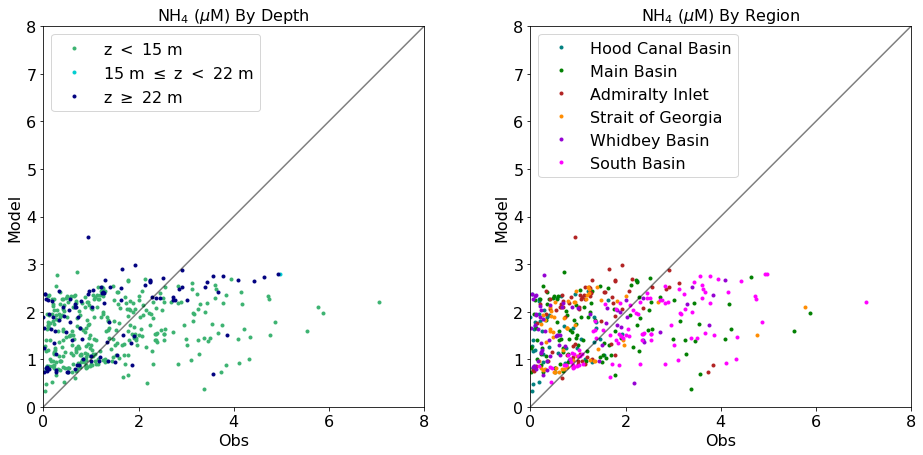

In [30]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,8))
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,8))
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

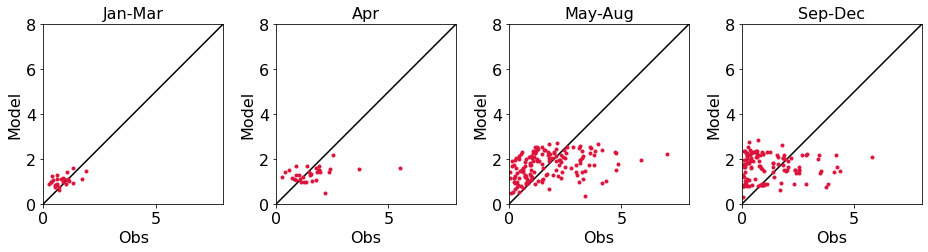

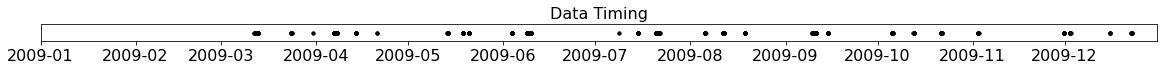

In [31]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,8))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Does model ammonium depend strongly on model salinity? 
### Does the residual of (model-obs ammonium) depend on model salinity?

Perhaps a question for me for later.

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Station          462 non-null    object        
 1   Desig            462 non-null    object        
 2   Descrip          462 non-null    object        
 3   Basin            462 non-null    object        
 4   Max_Depth        462 non-null    int64         
 5   Lat              462 non-null    float64       
 6   Lon              462 non-null    float64       
 7   Date             462 non-null    datetime64[ns]
 8   dtUTC            462 non-null    datetime64[ns]
 9   Z                462 non-null    float64       
 10  PO4(uM)D         462 non-null    float64       
 11  SiOH4(uM)D       462 non-null    float64       
 12  NO3(uM)D         462 non-null    float64       
 13  NO2(uM)D         462 non-null    float64       
 14  NH4(uM)D         462 non-null    float64  

model - observed silicon vs latitude. Lets give this a shot.

1. Create a function that calculates the differences.
2. create a function that stores the differences as a list

each of these plots takes place over a vastly different range of values and they must be altered appropriately.

In [69]:
def diff_by_lat(ax,obsvar,modvar,Lat,lname,lim):
    ps=[]
    obs0=et._deframe(data[obsvar])
    mod0=et._deframe(data[modvar])
    diff0=obs0-mod0
    lat0=et._deframe(data[Lat])
    ps.append(ax.plot(diff0,lat0,'.',color=cols[0],label=lname))
    ax.set_xlabel("latitude")
    ax.set_ylabel("Difference in Silicon")
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    return(ps)

Text(0.5, 1.0, 'dSi ($\\mu$M) By Region')

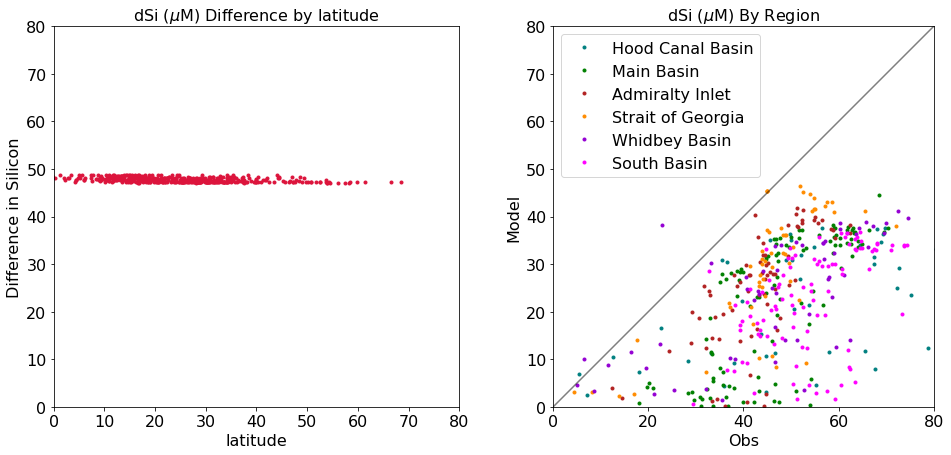

In [70]:
obsvar='Si'
modvar='mod_silicon'
Lat='Lat'

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps=diff_by_lat(ax[0],obsvar,modvar,Lat,lname="test",lim=(0,80)) #ps is the important stuff. L is just which I probably do not need right now.
ax[0].set_title(f'dSi ($\mu$M) Difference by latitude')

ps,l=byRegion(ax[1],obsvar,modvar,(0,80))
ax[1].set_title('dSi ($\mu$M) By Region')

Hmmmm, Not bad. I imagine it could definitely use some work though. Like a lot of work. 

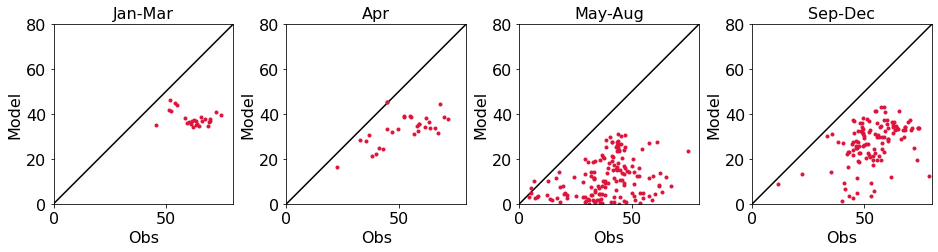

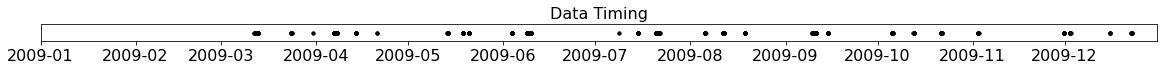

In [35]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,80))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

In [36]:
statsDict

{2009: {'NO3': OrderedDict([('z < 15 m',
                {'N': 343,
                 'Bias': -3.349258847128729,
                 'RMSE': 5.968963876696454,
                 'WSS': 0.8565032047363436}),
               ('15 m < z < 22 m',
                {'N': 1,
                 'Bias': 3.790170401334745,
                 'RMSE': 3.790170401334745,
                 'WSS': 0.0}),
               ('z >= 22 m',
                {'N': 98,
                 'Bias': -1.4643751642077554,
                 'RMSE': 4.247759222380062,
                 'WSS': 0.7178075649686105}),
               ('z > 50 m', {'N': 0, 'Bias': nan, 'RMSE': nan, 'WSS': nan}),
               ('all',
                {'N': 442,
                 'Bias': -2.915190905556967,
                 'RMSE': 5.628629552811155,
                 'WSS': 0.8657539093009216}),
               ('z < 15 m, JFM',
                {'N': 26,
                 'Bias': -4.370174708274693,
                 'RMSE': 7.417235894887004,
                 